<a href="https://colab.research.google.com/github/IgnacioPardo/SNN/blob/main/SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Network

Simple Red Neuronal (Perceptrón) para la materia Tecnologías Exponenciales - TIC

Inspirado en https://github.com/jonasbostoen/simple-neural-network

### Librerias

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import networkx as nx
from random import random as rand
import itertools

In [24]:
np.random.seed(1)

### Funciones

In [25]:
def sigmoid(x):
    return 1 / ( 1 + np.exp(-x) )

# sigmoid = lambda x : 1 / ( 1 + np.exp(-x) )

def sigmoid_derivative(x):
    return x * (1 - x)

# sigmoid_derivative = lambda x : x * (1 - x)


Sigmoid Function
$$\operatorname{f}(x)=\frac{1}{1+e^{(-x)}}$$

Sigmoid Derivative Function
$$\operatorname{f'}(x)=x \times (1-x)$$

#### Visualización Función Sigmoide

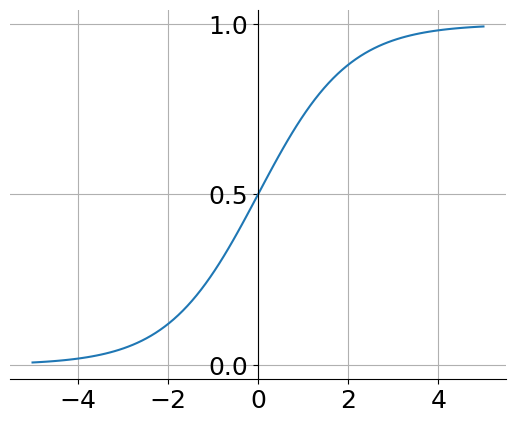

In [26]:
x = np.linspace(-5,5,100)
y = sigmoid(x)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.plot(x, y)
plt.locator_params(axis='y', nbins=3)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid()

Funciones de Activación:
las funciones de activación determinan que pinta va a tener nuestro modelo. Por ejemplo, en este caso, la función sigmoide nos aproxima la salida a 0 o 1.

## Setup

### Values

#### Training Values

In [27]:
info: pd.DataFrame = pd.read_csv('disney_movies.csv')
info = info.drop(["movie_title"], axis = 1)
info['release_date'] = pd.to_datetime(info['release_date'])
info['release_date'] = info['release_date'].dt.year

In [28]:
training_inputs = info.drop(["genre"], axis = 1)
training_inputs = pd.get_dummies(training_inputs, columns=['mpaa_rating'])
training_inputs = training_inputs * 1
training_inputs = training_inputs.values

In [29]:
training_outputs = info["genre"]
training_outputs = pd.get_dummies(training_outputs)
training_outputs = training_outputs * 1
training_outputs = training_outputs.values

In [30]:
len(training_inputs[0])

8

In [31]:
len(training_outputs[0])

12

Estructura de la red neuronal: definimos la cantidad de entradas y salidas que va a tener nuestra red neuronal. En este caso, tenemos 8 entradas (si contamos las diferentes mpaa rating por separado) y 12 salidas.

In [32]:
display(training_inputs)
display(training_outputs)

array([[      1937,  184925485, 5228953251, ...,          0,          0,
                 0],
       [      1940,   84300000, 2188229052, ...,          0,          0,
                 0],
       [      1940,   83320000, 2187090808, ...,          0,          0,
                 0],
       ...,
       [      2016,  232532923,  232532923, ...,          0,          1,
                 0],
       [      2016,  246082029,  246082029, ...,          1,          0,
                 0],
       [      2016,  529483936,  529483936, ...,          0,          1,
                 0]], dtype=int64)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [33]:
training_values = np.concatenate((training_inputs.T, training_outputs.T)).T
table = lambda arr : display(HTML(tabulate.tabulate(arr, tablefmt='html')))
#table(training_values)

#### Synaptic weights 

In [34]:
n = training_inputs.shape[1]
synaptic_weights = 1 + np.random.random((n, 12))

synaptic_weights

array([[1.417022  , 1.72032449, 1.00011437, 1.30233257, 1.14675589,
        1.09233859, 1.18626021, 1.34556073, 1.39676747, 1.53881673,
        1.41919451, 1.6852195 ],
       [1.20445225, 1.87811744, 1.02738759, 1.67046751, 1.4173048 ,
        1.55868983, 1.14038694, 1.19810149, 1.80074457, 1.96826158,
        1.31342418, 1.69232262],
       [1.87638915, 1.89460666, 1.08504421, 1.03905478, 1.16983042,
        1.8781425 , 1.09834683, 1.42110763, 1.95788953, 1.53316528,
        1.69187711, 1.31551563],
       [1.68650093, 1.83462567, 1.01828828, 1.75014431, 1.98886109,
        1.74816565, 1.28044399, 1.78927933, 1.10322601, 1.44789353,
        1.9085955 , 1.29361415],
       [1.28777534, 1.13002857, 1.01936696, 1.67883553, 1.21162812,
        1.26554666, 1.49157316, 1.05336255, 1.57411761, 1.14672857,
        1.58930554, 1.69975836],
       [1.10233443, 1.41405599, 1.69440016, 1.41417927, 1.04995346,
        1.53589641, 1.66379465, 1.51488911, 1.94459476, 1.58655504,
        1.90340192,

## Training

Para obtener un resultado a partir de los inputs y los synaptic weights se realiza la siguiente función:

$$\sum_{i=0}^{n}{x_iw_i}$$

Y se le aplica la función sigmoide para normalizar al rango 0, 1

Por ejemplo, si nuestros inputs $x_i$ son `[1, 1, 1]` y nuestros pesos sinapticos $w_i$ son `[[11.30926442], [-0.20511667], [-5.4500033]]`

Nos resulta la cuenta
$$[1 \times 11.30926442] + [1 \times (-0.20511667)] + [1 \times (-5.4500033)] = 5.6541444499999995$$

Con la función sigmoide es facil ver como $$\operatorname{sigmoid}(5.65) \approx 1$$

In [35]:
eval_NN = lambda x, w: sigmoid(np.dot(x, w))

In [36]:
# 50000 epochs
for iteration in range(50000):

    # Arranca con los valores de training
    input_layer = training_inputs

    # Genera un output haciendo la suma de los valores de input multiplicados por su peso sinaptico, y aplicandole la función sigmoide para normalizar a -1, 1
    outputs = eval_NN(input_layer, synaptic_weights)

    # Calculo el error
    error = training_outputs - outputs
    #forward propagation

    # Ajusto los pesos en funcion al error y al resultado obtenido
    adjustments = error * sigmoid_derivative(outputs)
    synaptic_weights += np.dot(input_layer.T, adjustments)
    #back propagation

Acá ocurren varios procesos qu ayudan a la red mejorar los resultados: 

Forward propagation: se realiza todo el recorrido de la red neuronal para, al finalizar, obtener un resultado.

Back propagation: se realiza el recorrido inverso para ajustar los pesos sinapticos y mejorar el resultado.

Gradiente descendiente: se realiza el ajuste de los pesos sinapticos en base a la derivada de la función de activación.

In [37]:
print('Synaptic weights after training')
print(synaptic_weights)

print('Outputs after training: ')
print(outputs)

Synaptic weights after training
[[1.417022   1.72032449 1.00011437 1.30233257 1.14675589 1.09233859
  1.18626021 1.34556073 1.39676747 1.53881673 1.41919451 1.6852195 ]
 [1.20445225 1.87811744 1.02738759 1.67046751 1.4173048  1.55868983
  1.14038694 1.19810149 1.80074457 1.96826158 1.31342418 1.69232262]
 [1.87638915 1.89460666 1.08504421 1.03905478 1.16983042 1.8781425
  1.09834683 1.42110763 1.95788953 1.53316528 1.69187711 1.31551563]
 [1.68650093 1.83462567 1.01828828 1.75014431 1.98886109 1.74816565
  1.28044399 1.78927933 1.10322601 1.44789353 1.9085955  1.29361415]
 [1.28777534 1.13002857 1.01936696 1.67883553 1.21162812 1.26554666
  1.49157316 1.05336255 1.57411761 1.14672857 1.58930554 1.69975836]
 [1.10233443 1.41405599 1.69440016 1.41417927 1.04995346 1.53589641
  1.66379465 1.51488911 1.94459476 1.58655504 1.90340192 1.1374747 ]
 [1.13927635 1.80739129 1.39767684 1.1653542  1.92750858 1.34776586
  1.7508121  1.72599799 1.88330609 1.62367221 1.75094243 1.34889834]
 [1.269927

## Eval

In [38]:
#table(training_values)

In [39]:
large = lambda x : display(HTML('<p style="font-size: 50px; color: #66D148">'+str(x)+'</p>'))

In [40]:
a = 1 #@param {type:"integer"}
c = 1 #@param {type:"integer"}
b = 1 #@param {type:"integer"}

#input_layer = np.array([a, b, c])
res = sigmoid(np.dot(input_layer, synaptic_weights))[0]
display(res)

thresh = 0.01
out = 0 if (res < thresh).all() else 1

large(out)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Bonus

Función Softmax: la función softmax, a diferencia de la sigmoide, nos da un resultado menor a 0 para cada una de nuestras clases, haciendo que el total de las sumas de estas de 1, quedándose asi con la de mayor porcentaje. De esta manera, podemos ver la probabilidad de que nuestro resultado sea de una clase u otra, por esto se utiliza para resolver problemas de clasificacion mutualmente excluyentes.
En el código, deberíamos de cambiar cada vez que se utiliza la función sigmoid por la softmax, tanto en el entrenamiento como en la evaluación.